In [120]:
import pandas as pd
import matplotlib.pyplot as plt
from rank_bm25 import BM25Okapi     # https://github.com/dorianbrown/rank_bm25

# Get the top n of result
top_n = 5


content_data_path_1 = "../demos/demo_v0/resources/content/help_guides_data.json"
content_data_path_2 = "../demos/demo_v0/resources/content/sellercenter_crawled_data.json"
content_df1 = pd.read_json(content_data_path_1)
content_df2 = pd.read_json(content_data_path_2)
content_result = pd.concat([content_df1, content_df2], ignore_index=True)
content_result.to_json("content_data_merged.json", index=False)

# Load labeled data
labeled_data_path_1 = "../data/eval/output/help_guides/questions.json"
labeled_data_path_2 = "../data/eval/output/seller_center/questions.json"
labeled_df1 = pd.read_json(labeled_data_path_1)
labeled_df2 = pd.read_json(labeled_data_path_2)
labeled_result = pd.concat([labeled_df1, labeled_df2], ignore_index=True)
labeled_result.to_json("labeled_data_merged.json", index=False)

In [121]:
labeled_result

,question,answer,url
0,What are the two ways to buy items on eBay?,You can buy items on eBay either with Buy It N...,https://www.ebay.com/help/buying/buy-now/buyin...
1,How can I track my buying activity on eBay?,You can keep track of all your buying activity...,https://www.ebay.com/help/buying/buy-now/buyin...
2,What should I do if an item I bought hasn't ar...,You can get help with an item that hasn't arri...,https://www.ebay.com/help/buying/buy-now/buyin...
3,How can I make an offer on an item?,"On some listings, sellers accept offers, and y...",https://www.ebay.com/help/buying/buy-now/buyin...
4,What options do I have if I want to cancel my ...,"If you've bought an item and made a mistake, e...",https://www.ebay.com/help/buying/buy-now/buyin...
...,...,...,...
1375,What is the new feature being introduced for e...,The new feature being introduced is combined s...,https://www.ebay.com/sellercenter/resources/se...
1376,How will combined shipping benefit buyers?,Combined shipping will offer lower shipping co...,https://www.ebay.com/sellercenter/resources/se...
1377,Can sellers offer multiple shipping options fo...,"Yes, sellers will soon be able to offer both e...",https://www.ebay.com/sellercenter/resources/se...
1378,What are the current price limits for eBay Int...,"Items up to $2,500 are eligible for eBay Inter...",https://www.ebay.com/sellercenter/resources/se...


In [122]:
content_result

,url,content
0,https://www.ebay.com/help/buying/buy-now/buyin...,Help webpage title: How buying works on eBay \...
1,https://www.ebay.com/help/buying/search-tips/w...,Help webpage title: Your Watchlist \nHelp webp...
2,https://www.ebay.com/help/buying/search-tips/p...,Help webpage title: Your purchase history \nHe...
3,https://www.ebay.com/help/buying/buy-now/makin...,Help webpage title: Making a Best Offer \nHelp...
4,https://www.ebay.com/help/buying/search-tips/r...,Help webpage title: Your recently viewed items...
...,...,...
542,https://www.ebay.com/sellercenter/resources/ch...,1099-K and Tax Withholding FAQs\nImportant inf...
543,https://www.ebay.com/sellercenter/resources/eb...,The eBay and TaxAct® Partnership\nImportant in...
544,https://www.ebay.com/sellercenter/resources/ta...,Tax information\nUnderstand tax obligations th...
545,https://www.ebay.com/sellercenter/resources/se...,Seasonal playbook\nGreat tips for any peak sel...


In [123]:
# Init the BM25 model
token_corpus = content_result["content"].apply(lambda x: list(filter(None, x.split()))).tolist()
bm25 = BM25Okapi(token_corpus)

In [124]:
url_list = content_result["url"].tolist()
tokenized_query = labeled_result["question"].apply(lambda x: bm25.get_top_n(x.split(), url_list, n=5))

In [125]:
hit_rate = []
i = 0

for l in tokenized_query:
    try:
        hit_index = l.index(labeled_result["url"][i])
        hit_rate.append(l.index(labeled_result["url"][i]))
    except:
        hit_rate.append("Faild")
    i += 1

In [126]:
value_counts = pd.Series(hit_rate).value_counts()
value_counts

0        562
Faild    502
1        161
2         71
3         58
4         26
Name: count, dtype: int64

In [127]:
total_len = value_counts.sum()
total_len

1380

In [128]:
value_counts = value_counts / total_len
value_counts = value_counts[value_counts.index != "Faild"]
value_counts

0    0.407246
1    0.116667
2    0.051449
3    0.042029
4    0.018841
Name: count, dtype: float64

In [129]:
# Get the top_N acc rate
res = value_counts.cumsum()
res = res.to_dict()

In [130]:
def calculate_mAP(hit_counts, total_cnt=1, k=5):
    """
    Calculate the Mean Average Precision (mAP) based on hit counts and the total count.

    Parameters:
    hit_counts (dict): A dictionary where the key is the rank (1-based index), for example: {1: 1820, 2: 2132, 3: 2317, 4: 2440, 5: 2531})
                       and the value is the number of hits up to that rank.
    total_cnt (int): The total number of items for normalization.

    Returns:
    float: The calculated mAP value.
    """
    # Initialize a list to store hits at each rank (0 to k)
    hit_in_k = [0] * 5
    # print("k is:", k)
    # print("hit_counts.items() is:", hit_counts.items())
    # Populate the list with cumulative hits at each rank from hit_counts
    for idx, count in hit_counts.items():
        hit_in_k[idx-1] = count

    # Calculate hits at each individual rank by subtracting cumulative values
    for i in range(k-1, 1, -1):
        hit_in_k[i] = hit_in_k[i] - hit_in_k[i - 1]

    # Compute the mAP by summing the precision at each rank and normalizing by total count
    map = sum([hit_in_k[i] * 1 / i for i in range(1, k)]) / total_cnt

    return map

In [131]:
# calculate the mAP
mAP = calculate_mAP(res, 1)
mAP

0.5454106280193237

['Top_1', 'Top_2', 'Top_3', 'Top_4', 'Top_5', 'mAP']
[0.4072463768115942, 0.5239130434782608, 0.5753623188405796, 0.6173913043478261, 0.636231884057971, 0.5454106280193237]


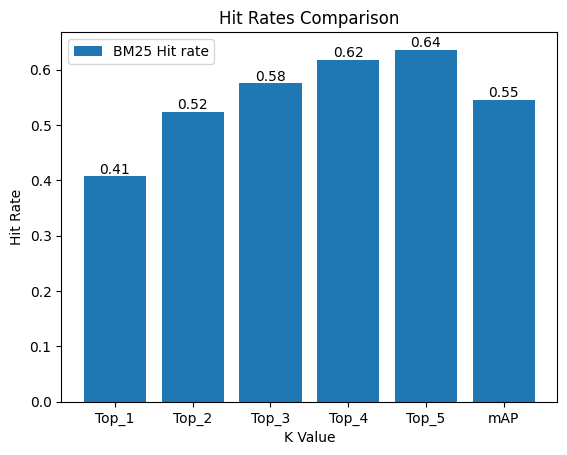

In [132]:
vci = value_counts.index + 1

name = ["Top_" + str(i) for i in vci.tolist()]

name = name + ["mAP"]


x = list(res.values()) + [mAP]
x = [float(i) for i in x]
print("Scores are:", x)
bar1 = plt.bar(name,x,label="BM25 Hit rate")
plt.xlabel("K Value")
plt.ylabel("Hit Rate")
plt.title("Hit Rates Comparison")
plt.legend()

for bar in bar1:
    plt.text(
        bar.get_x() + bar.get_width() / 2,      # X-coordinate of the bar center
        bar.get_height(),                       # Y-coordinate of the bar height
        f'{bar.get_height():.2f}',              # Text (hit rate value)
        ha='center', va='bottom', fontsize=10   # Alignment and font size
    )

# Show plot
plt.show()